https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7

In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame


start = datetime.datetime(2017, 1, 1)
end = datetime.datetime(2020, 12, 31)

df = web.DataReader("EXK", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-24,4.60,4.44,4.54,4.58,1279100,4.58
2020-12-28,4.80,4.62,4.71,4.64,3051300,4.64
2020-12-29,4.70,4.53,4.66,4.61,2852300,4.61
2020-12-30,5.07,4.56,4.61,5.06,4184400,5.06
2020-12-31,5.24,4.85,5.15,5.04,4374100,5.04


In [51]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

In [18]:
df_ticker = web.get_quote_yahoo('EXK')
bookval = df_ticker['bookValue']
marketcap = df_ticker['marketCap']
price = marketcap.values[0]
print(f"{price:,}".format(price).replace(',','.'))


886.567.360


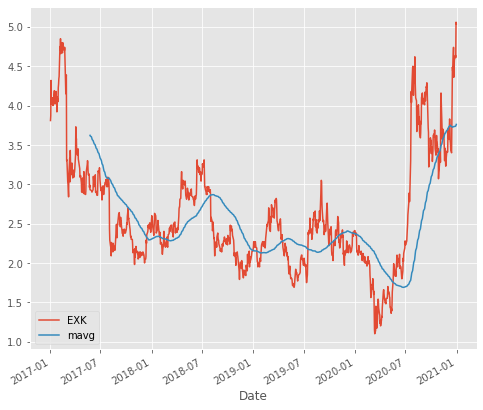

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl

close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

# Adjusting the size of matplotlib

mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='EXK')
mavg.plot(label='mavg')
plt.legend()

<AxesSubplot:xlabel='Date'>

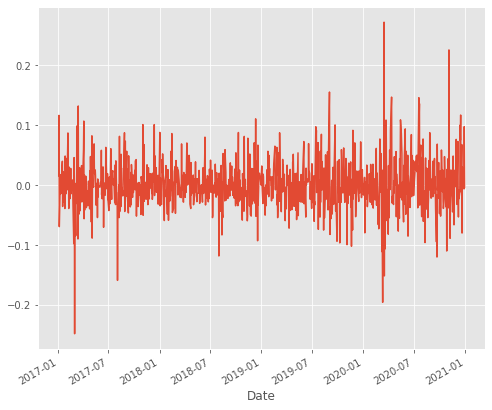

In [53]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [76]:
dfcomp = web.DataReader(['EXK','AG', 'GOLD', 'FM'],'yahoo',start=start,end=end)['Adj Close']
dfcomp.head()
dfcomp.keys()

Index(['EXK', 'AG', 'GOLD', 'FM'], dtype='object', name='Symbols')

In [78]:
dfcomp.head()

Symbols,EXK,AG,GOLD,FM
Date,,,,
2017-01-03,3.81,8.08,15.615654,22.183540
2017-01-04,3.87,8.37,15.625176,22.430319
2017-01-05,4.32,9.22,16.549356,22.606588
2017-01-06,4.02,8.79,16.130136,22.862179
2017-01-09,4.03,8.88,16.168247,22.818113


In [77]:
for col in dfcomp.columns: 
    print(col) 

EXK
AG
GOLD
FM


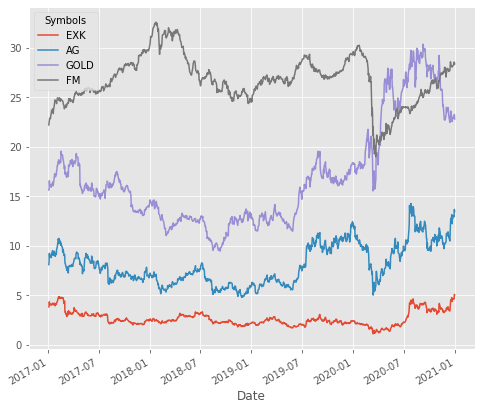

In [72]:
lines = dfcomp.plot.line()

In [55]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()
corr.head()

Symbols,EXK,AG,GOLD,FM
Symbols,,,,
EXK,1.000000,0.780700,0.611355,0.233710
AG,0.780700,1.000000,0.709887,0.219503
GOLD,0.611355,0.709887,1.000000,0.203787
FM,0.233710,0.219503,0.203787,1.000000


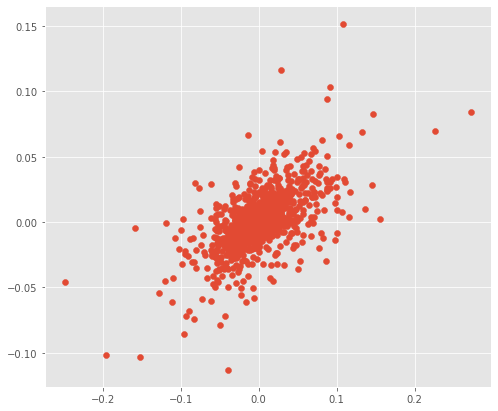

In [56]:
plt.scatter(retscomp.EXK, retscomp.GOLD)
#plt.xlabel(‘Returns EXK’)
#plt.ylabel(‘Returns GOLD’)

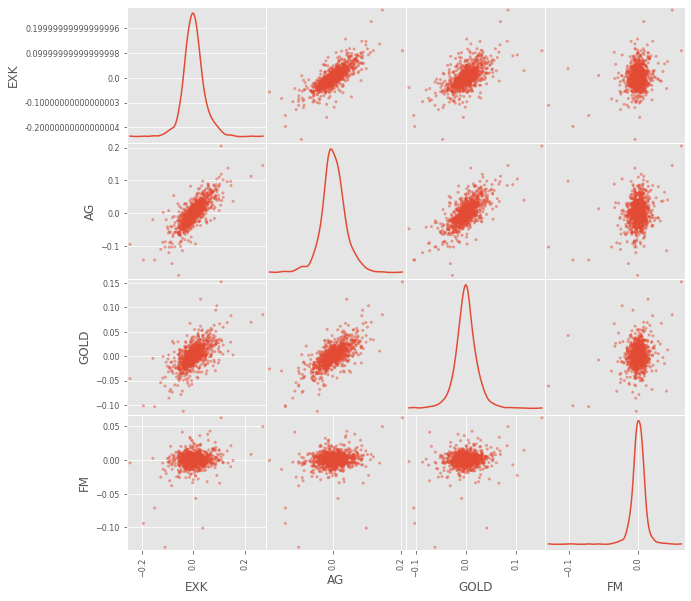

In [57]:
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

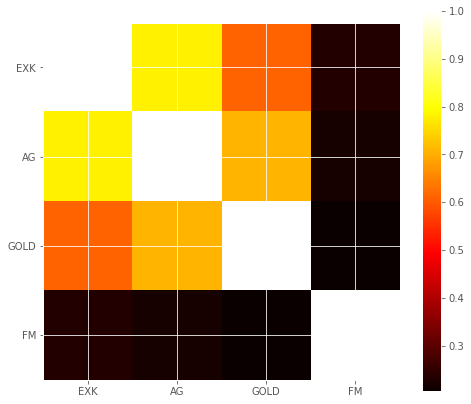

In [58]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

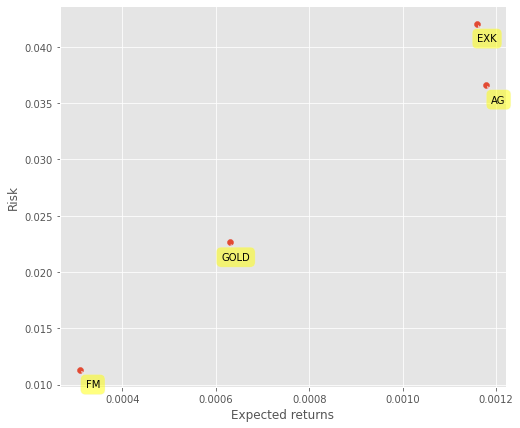

In [59]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [60]:
df.head()
df.keys()

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [61]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_Change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [62]:
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_Change
Date,,,,
2017-01-03,3.81,2185400,6.824147,5.248621
2017-01-04,3.87,1946200,4.909562,-0.257738
2017-01-05,4.32,4069200,8.333331,8.270681
2017-01-06,4.02,3896600,10.696519,-3.365382
2017-01-09,4.03,2187900,5.707196,-0.982800


In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import math
import sklearn.preprocessing as preprocessing

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [64]:
# Linear regression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('ridge', Ridge())])

In [65]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=2)

In [66]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)
# results
print('The linear regression confidence is {}'.format(confidencereg))
print('The quadratic regression 2 confidence {}'.format(confidencepoly2))
print('The quadratic regression 3 confidence is {}'.format(confidencepoly3))
print('The knn regression confidence is {}'.format(confidenceknn))

The linear regression confidence is 0.7283439094583374
The quadratic regression 2 confidence 0.7247024064594825
The quadratic regression 3 confidence is 0.7088157281973754
The knn regression confidence is 0.6244352698299098


In [67]:
forecast_set = clfknn.predict(X_lately)
dfreg['Forecast'] = np.nan

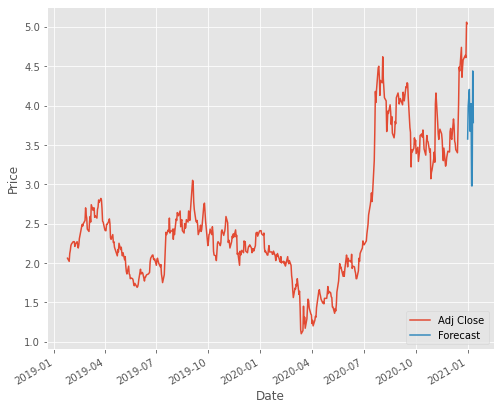

In [68]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()